In [29]:
import numpy as np
import csv
import png
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [13, 13]
mpl.rcParams['figure.dpi'] = 72
from matplotlib import pyplot as plt
import cv2 as cv

undistort_mtx = np.array([[292.00435998,   0.,         184.46231254],
 [  0.,         290.13777429, 145.5500931 ],
 [  0.,           0.,           1.        ]])

undistort_newcameramtx = np.array([[219.46858215,   0.,         184.57709806],
 [  0.,         207.91963196, 150.10088495],
 [  0.,           0. ,          1. ,       ]])

undistort_dist = np.array([[-0.35620774,  0.35086004, -0.00051231,  0.0015257,  -0.38282677]])

undistort_roi = (46,46,265,205)

sys.setrecursionlimit(100000)

def load_n_undistort(filename):
    with open(filename, newline='') as csvfile:
        data = list(csv.reader(csvfile,  delimiter=';'))
        
    dataraw = np.array(data)
    dataraw = dataraw.astype(np.uint16).reshape((286,352))
    dataRGB = np.zeros((286*352*3),dtype=float).reshape((286,352,3))
    dataRGB[:,:,0] = (((dataraw[:,:]-np.amin(dataraw).astype(float))/(np.amax(dataraw)-np.amin(dataraw))).astype(float)).astype(float)
    dataRGB[:,:,1] = (((dataraw[:,:]-np.amin(dataraw).astype(float))/(np.amax(dataraw)-np.amin(dataraw))).astype(float)).astype(float)
    dataRGB[:,:,2] = (((dataraw[:,:]-np.amin(dataraw).astype(float))/(np.amax(dataraw)-np.amin(dataraw))).astype(float)).astype(float)
    dst = cv.undistort(dataRGB, undistort_mtx, undistort_dist, None, undistort_newcameramtx)
    x, y, w, h = undistort_roi
    src = dst[y:y+h, x:x+w]
    return src

def sobel_filter_2D(src):
    sobel_x = np.array([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]])
    sobel_y = np.array([[-1., -2., -1.],
                        [0., 0., 0.],
                        [1., 2., 1.]])
    if len(src.shape)==3:
        width, height, channels = src.shape
    elif len(src.shape)==2:
        width, height = src.shape
        channels = 1
    else:
        return
    srcfloat = np.zeros(src.shape,dtype=float)
    if (np.amax(src)>1.0):
        for c in range(channels):
            for x in range(width):
                for y in range(height):
                    srcfloat[x,y,c] = float(src[x,y,c]/255) 
    else:
        srcfloat = np.copy(src) 
    dst_x = np.zeros(src.shape,dtype=float)
    dst_y = np.zeros(src.shape,dtype=float)
    dst = np.zeros(src.shape,dtype=float)
    dst_x = cv.filter2D(srcfloat,-1,sobel_x)
    dst_y = cv.filter2D(srcfloat,-1,sobel_y)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = dst_x[x,y,c]-dst_y[x,y,c]
    return dst

def laplace_filter_2D(src):
    laplace = np.array([[-1., -1., -1.],
                        [-1., 8., -1],
                        [-1., -1., -1]])
    if len(src.shape)==3:
        width, height, channels = src.shape
    elif len(src.shape)==2:
        width, height = src.shape
        channels = 1
    else:
        return
    dst = np.zeros(src.shape,dtype=float)
    dst = cv.filter2D(src,-1,laplace)
    return dst

def sub_images_2D(src_pos, src_neg):
    if src_pos.shape != src_neg.shape:
        return
    if len(src_pos.shape)==3:
        width, height, channels = src_pos.shape
    elif len(src_pos.shape)==2:
        width, height = src_pos.shape
        channels = 1
    else:
        return
    dst = np.zeros(src_pos.shape,dtype=float)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = src_pos[x,y,c]-src_neg[x,y,c]
    return dst

def sq_sum_images_2D(src_pos, src_neg):
    if src_pos.shape != src_neg.shape:
        return
    if len(src_pos.shape)==3:
        width, height, channels = src_pos.shape
    elif len(src_pos.shape)==2:
        width, height = src_pos.shape
        channels = 1
    else:
        return
    dst = np.zeros(src_pos.shape,dtype=float)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = np.sqrt(src_pos[x,y,c]*src_pos[x,y,c]+src_neg[x,y,c]*src_neg[x,y,c])
    return dst

def sum_images_2D(src_pos, src_neg):
    if src_pos.shape != src_neg.shape:
        return
    if len(src_pos.shape)==3:
        width, height, channels = src_pos.shape
    elif len(src_pos.shape)==2:
        width, height = src_pos.shape
        channels = 1
    else:
        return
    dst = np.zeros(src_pos.shape,dtype=float)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = src_pos[x,y,c]+src_neg[x,y,c]
    return dst

def mul_images_2D(src1, src2):
    if src1.shape != src2.shape:
        return
    if len(src1.shape)==3:
        width, height, channels = src1.shape
    elif len(src1.shape)==2:
        width, height = src1.shape
        channels = 1
    else:
        return
    dst = np.zeros(src1.shape,dtype=float)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = src1[x,y,c]*src2[x,y,c]
    return dst

def boost_image_2D(src1):
    if len(src1.shape)==3:
        width, height, channels = src1.shape
    elif len(src1.shape)==2:
        width, height = src1.shape
        channels = 1
    else:
        return
    dst = np.zeros(src1.shape,dtype=float)
    maximum = np.amax(src1)
    minimum = np.amin(src1)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = (src1[x,y,c]-minimum)/(maximum-minimum)
    return dst


def x_in_range(x):
        return (x>=0) and (x<205)
def y_in_range(y):
        return (y>=0) and (y<265)

def fillArea(x,y,src1, brightness, bw_image):
    if len(src1.shape)==3:
        width, height, channels = src1.shape
    elif len(src1.shape)==2:
        width, height = src1.shape
        channels = 1
    else:
        return
    dst_tmp = np.zeros((width, height), dtype=np.uint8)
    dst = np.zeros(src1.shape, dtype=float)
    mask = np.zeros((width+2, height+2), dtype=np.uint8)
    maximum = np.amax(src1)
    minimum = np.amin(src1)
    for c in range(channels):
        for m in range(width):
            for n in range(height):
                dst_tmp[m,n] = np.uint8(((src1[m,n,c]-minimum)/(maximum-minimum))*255)
    cv.floodFill(dst_tmp,mask,seedPoint=(x,y),newVal=255,upDiff=brightness,loDiff=brightness, flags=cv.FLOODFILL_FIXED_RANGE)
    maximum = np.amax(dst_tmp)
    minimum = np.amin(dst_tmp)
    for c in range(channels):
        for m in range(width):
            for n in range(height):
                dst[m,n,c] = float(((dst_tmp[m,n]-minimum)/(maximum-minimum)))
    mean = 0
    sum = 0
    num = 0

    for m in range(width):
       for n in range(height):
            if (mask[m,n] > 0):
                sum += bw_image[m,n,0] 
                num += 1
    mean = sum / num
    print("mean = "+str(mean))
    sum = 0
    num = 0
    for m in range(width):
       for n in range(height):
            if (mask[m,n] > 0):
                sum += (bw_image[m,n,0]-mean)*(bw_image[m,n,0]-mean)
                num += 1    
    print("variance = "+str(sum / num))
    print("num = "+str(num))
    snr = mean / np.sqrt(sum / num)
    return dst, snr


Load flat image

In [30]:
num_images = 19
ampl = load_n_undistort("../data/ToFData/ampl_flat_roof_diffusor_16.txt")
width, height, channels = ampl.shape
radial_arr = np.zeros((width, height, channels, num_images),dtype=float)
filenameprefix = "../data/ToFData/radial_flat_roof_diffusor_"
filenamesuffix = ".txt"
for i in range(num_images):
    filename = filenameprefix+str(i)+filenamesuffix
    radial_arr[:,:,:,i] = load_n_undistort(filename)
    radial_arr[:,:,:,i] = cv.GaussianBlur(radial_arr[:,:,:,i],(0,0),3)
radial = np.mean(radial_arr, axis=3)

It's a cos-Function...

(205, 265, 3)


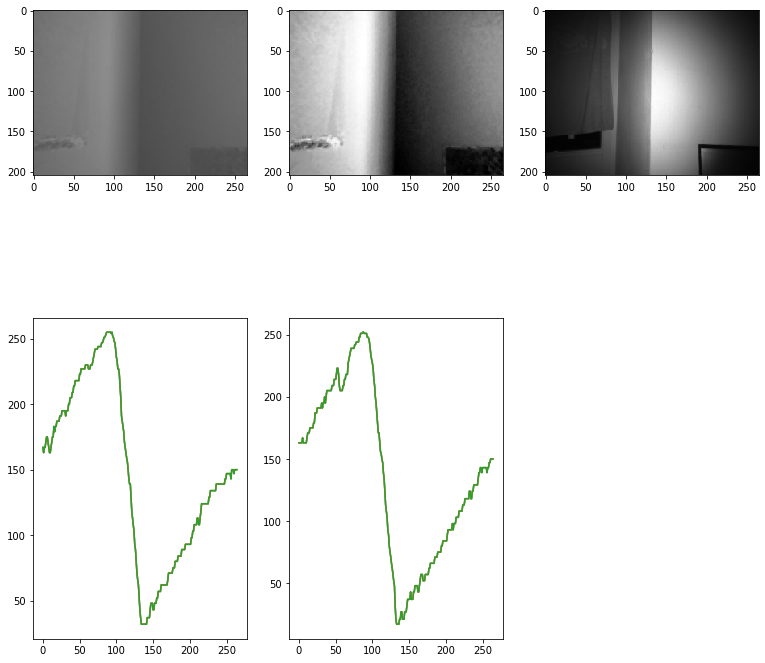

In [31]:
radial_1 = load_n_undistort("../data/ToFData/radial_test_diffusor_0.txt")
ampl_1 = load_n_undistort("../data/ToFData/ampl_test_diffusor_0.txt")
if len(radial.shape)==3:
    width, height, channels = radial.shape
elif len(radial.shape)==2:
    width, height = radial.shape
    channels = 1

cos_a = np.zeros(radial.shape,dtype=float)
print(radial.shape)
for c in range(channels):
    for m in range(width):
        for n in range(height):
            cos_a[m,n,c] = radial[102,132,c]/radial[m,n,c]
flattened = mul_images_2D(radial_1,cos_a)
flat_int = np.zeros(flattened.shape,dtype=np.uint8)
for c in range(channels):
    for m in range(width):
        for n in range(height):
            flat_int[m,n,c] = np.uint8(flattened[m,n,c]*255)

flat_histoeq = np.zeros(flattened.shape,dtype=np.uint8)
flat_histoeq[:,:,0] = cv.equalizeHist(flat_int[:,:,0])
flat_histoeq[:,:,1] = cv.equalizeHist(flat_int[:,:,1])
flat_histoeq[:,:,2] = cv.equalizeHist(flat_int[:,:,2])
# flat_histoeq = cv.medianBlur(flat_histoeq,5)

plt.subplot(231)
plt.imshow(flattened, interpolation='nearest')
plt.subplot(232)
plt.imshow(flat_histoeq, interpolation='nearest')
plt.subplot(233)
plt.imshow(ampl_1, interpolation='nearest')
plt.subplot(234)
plt.plot(flat_histoeq[50,:])
plt.subplot(235)
plt.plot(flat_histoeq[105,:])
plt.show()

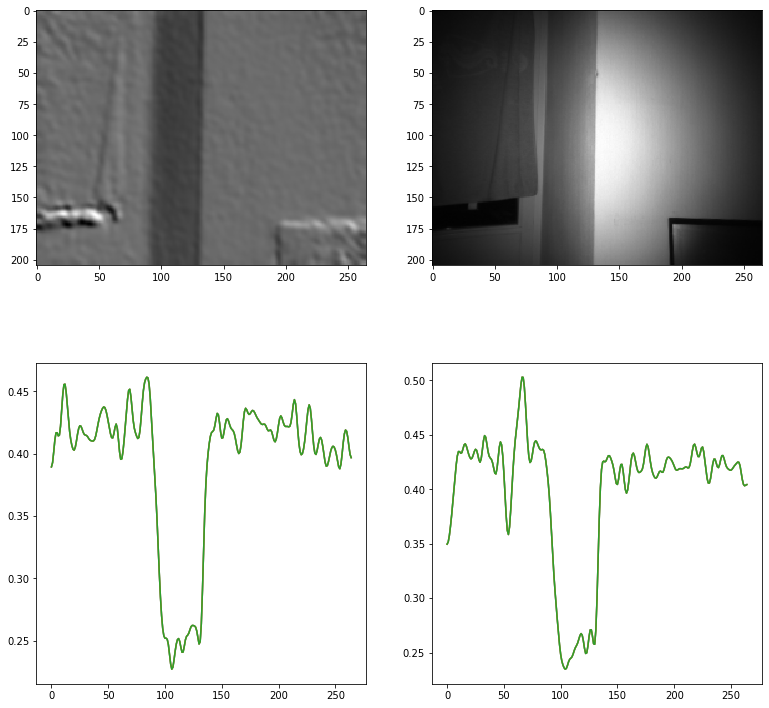

In [32]:
sobel1 = sobel_filter_2D(flat_int)
sobel1 = cv.GaussianBlur(sobel1,(0,0),2)
sobel1 = boost_image_2D(sobel1)
plt.subplot(221)
plt.imshow(sobel1[:,:], interpolation='nearest')
plt.subplot(222)
plt.imshow(ampl_1, interpolation='nearest')
plt.subplot(223)
plt.plot(sobel1[50,:])
plt.subplot(224)
plt.plot(sobel1[100,:])
plt.show()

mean = 0.4140351828062408
variance = 0.00045239280593738164
num = 26470
mean = 0.4167374481487218
variance = 0.0012289187781053482
num = 18814
mean = 0.2720140389207736
variance = 0.001793450014683265
num = 9167
mean = 0.4185946218542383
variance = 0.001075998980264694
num = 18609
19.46612025691604
11.88778488842906
6.423129535278355
12.761088315819903


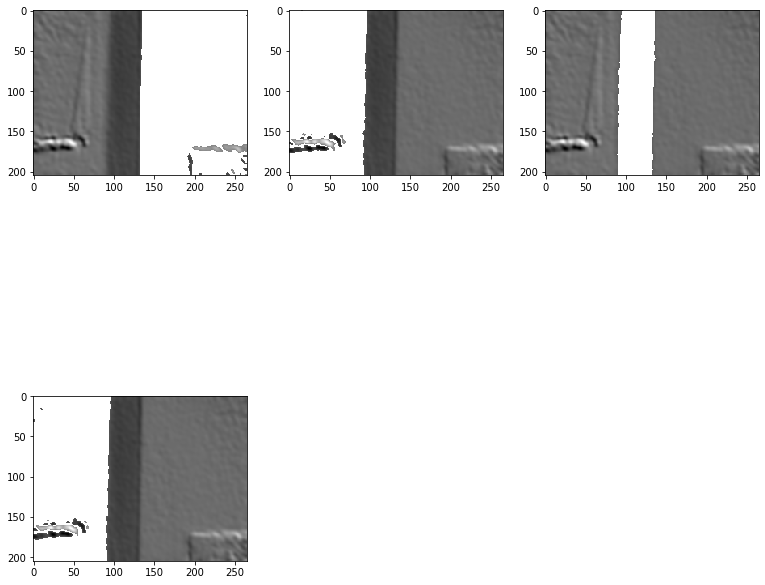

In [39]:

sobel1_eroded = cv.dilated(sobel1,(3,3))

res6, snr6 = fillArea(200,100,sobel1,25,sobel1_eroded)
res7, snr7 = fillArea(50,100,sobel1,25,sobel1_eroded)
res8, snr8 = fillArea(120,100,sobel1,25,sobel1_eroded)
res9, snr9 = fillArea(0,0,sobel1,25,sobel1_eroded)
print(snr6)
print(snr7)
print(snr8)
print(snr9)
plt.subplot(231)
plt.imshow(res6, interpolation='nearest')
plt.subplot(232)
plt.imshow(res7, interpolation='nearest')
plt.subplot(233)
plt.imshow(res8, interpolation='nearest')
plt.subplot(234)
plt.imshow(res9, interpolation='nearest')

plt.show()

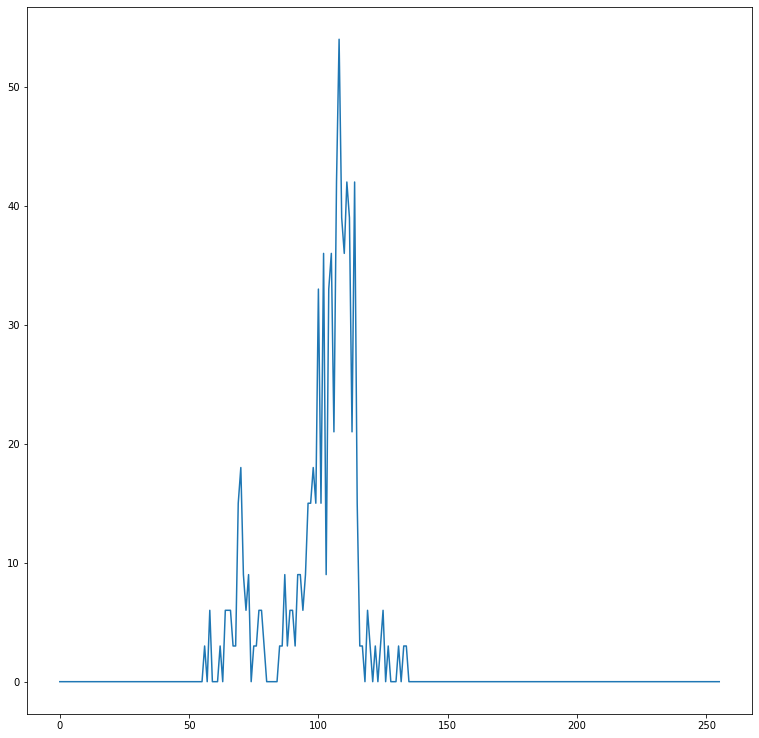

In [40]:
sobel1_int = np.zeros(flattened.shape,dtype=np.uint8)
for c in range(channels):
    for m in range(width):
        for n in range(height):
            sobel1_int[m,n,c] = np.uint8(sobel1[m,n,c]*255)

hist = cv.calcHist(sobel1_int,[0],None,[256],(0,256),accumulate=False)
plt.plot(hist)
plt.show()

In [41]:
res2 = sobel_filter_2D(res)
res2 = boost_image_2D(res2)
res2 = cv.GaussianBlur(res2,(0,0),3)
plt.subplot(221)
plt.imshow(res2, interpolation='nearest')
plt.subplot(222)
plt.imshow(ampl_1, interpolation='nearest')
plt.subplot(223)
plt.plot(res2[:,125])
plt.subplot(224)
plt.plot(np.amin(res2[102:108,:],axis=0))
plt.show()

NameError: name 'res' is not defined